In [2]:
import ase
import time
import sys
import torch
from torch.nn import MSELoss
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring
from skorch.callbacks.lr_scheduler import LRScheduler
from amptorch.gaussian import SNN_Gaussian
from amp.descriptor.gaussian import Gaussian
from amptorch.model import FullNN, CustomLoss, MAELoss, HuberLoss
from amptorch.data_preprocess import AtomsDataset, factorize_data, collate_amp, TestDataset
from md_work.md_utils import md_run, calculate_energies, calculate_forces, time_plots, kde_plots, calculate_rmse
from amptorch.skorch_model import AMP
from amptorch.skorch_model.utils import target_extractor, energy_score, forces_score
from amptorch.exp_repulsive import lj_optim
from amptorch.morse import lj_optim as lj_morse
from amptorch.lj_12_6 import lj_optim as lj_12_6
from torch.utils.data import DataLoader
from torch.nn import init
from skorch.utils import to_numpy
import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT
import matplotlib.pyplot as plt
import seaborn as sns
import sys

%matplotlib inline

import skorch.callbacks.base
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./results/checkpoints/forces_best_params.pt')

In [3]:
training_images = ase.io.read("../datasets/COCu_ber_50ps_300K.traj", ":100")
test_images = ase.io.read("../datasets/COCu_ber_50ps_300K.traj", ":2000")
# training_images = ase.io.read("../datasets/Cu_slab_ber_20ps_1000K.traj", ":100")
# test_images = ase.io.read("../datasets/Cu_slab_ber_20ps_1000K.traj", ":2000:10")

training_energies = [image.get_potential_energy() for image in training_images]
training_forces = [image.get_forces(apply_constraint=False) for image in training_images]
target_energies = [image.get_potential_energy() for image in test_images]
target_forces = [image.get_forces(apply_constraint=False) for image in test_images]

# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276 #EMT asap_cutoff: False

In [4]:
def parity_plots(x, y, xlabel, ylabel, title, num_atoms, dtype="energy"):
    if dtype == "energy":
        rmse = calculate_rmse(x, y, num_atoms, dtype=dtype)
        text = f"RMSE: {rmse:.6f}eV/atom"
    else:
        rmse = calculate_rmse(x, y, num_atoms, dtype=dtype)
        x = np.concatenate(np.array(x))
        y = np.concatenate(np.array(y))
        text = f"RMSE: {rmse:.6f}eV/A"
    print(text)
    grid = sns.jointplot(x, y)
    ax = grid.ax_joint
    _ = ax.set_ylabel(ylabel)
    _ = ax.set_xlabel(xlabel)
#     _ = ax.text(x=0, y=0, s=text,
#                 horizontalalignment='left',
#                 verticalalignment='top',
#                 fontsize=14)

In [5]:
def train(training_images, forcesonly=False, fit=False, p0=None, lj=None, method='Nelder-Mead'):
    label = 'test'
    lj_data = None
    scaling = None
    if lj is not None:
        params_dict = {"C": [], "O": [], "Cu": []}
        cutoff = Gs["cutoff"]
        if lj == 'rep':
            lj_model = lj_optim(training_images, p0, params_dict, cutoff, "test", forcesonly=forcesonly)
        elif lj == '12_6':
            lj_model = lj_12_6(training_images, p0, params_dict, cutoff, "test", forcesonly=forcesonly)
        elif lj == 'morse':
            lj_model = lj_morse(training_images, p0, params_dict, cutoff, "test", combo='mean')
        
        if fit:
            fitted_params = lj_model.fit(method=method)
        else:
            fitted_params = p0
        lj_energies, lj_forces, num_atoms = lj_model.lj_pred(training_images, fitted_params, params_dict)
        lj_data = [lj_energies, lj_forces, num_atoms, fitted_params, params_dict, lj_model]
        scaling = "rel"

    forcetraining = True
    training_data = AtomsDataset(training_images, SNN_Gaussian, Gs, forcetraining=forcetraining,
            label=label, cores=4, lj_data=lj_data, scaling=scaling)
    unique_atoms = training_data.elements
    fp_length = training_data.fp_length
    device = "cpu"
    
    torch.set_num_threads(1)

    net = NeuralNetRegressor(
        module=FullNN(unique_atoms, [fp_length, 3, 20], device, forcetraining=forcetraining),
        criterion=CustomLoss,
        criterion__force_coefficient=0.04,
        optimizer=torch.optim.LBFGS,
        optimizer__line_search_fn="strong_wolfe",
        lr=1e-1,
        batch_size=len(training_data),
        max_epochs=100,
        iterator_train__collate_fn=collate_amp,
        iterator_train__shuffle=False,
        iterator_valid__collate_fn=collate_amp,
        device=device,
        train_split= 0,
        callbacks=[
            EpochScoring(
                forces_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ),
            EpochScoring(
                energy_score,
                on_train=True,
                use_caching=True,
                target_extractor=target_extractor,
            ),
        ],
    )

    calc = AMP(training_data, net, label)
    calc.train()

    return calc

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.3439          0.3556        6.1649  7.9150
      2          0.0051          0.3022        0.1840  8.5178
      3          0.0033          0.1622        0.0532  7.8546
      4          0.0029          0.1494        0.0451  8.6323
      5          0.0024          0.1434        0.0414  8.5080
      6          0.0025          0.1293        0.0337  8.1486
      7          0.0017          0.1063        0.0227  8.4579
      8          0.0011          0.0692        0.0096  8.5371
      9          0.0008          0.0607        0.0074  8.3828
     10          0.0005          0.0531        0.0057  8.2711
     11          0.0004          0.0484        0.0047  8.5867
     12          0.0005          0.0466        0.0044  8.5779
     13          0.0005          0.0454        0.0041  8.5069
     14          

     98          0.0001          0.0268        0.0014  7.3087
     99          0.0002          0.0267        0.0014  6.9450
    100          0.0001          0.0266        0.0014  6.8997
RMSE: 0.000082eV/atom
RMSE: 0.026534eV/A
RMSE: 0.050595eV/atom
RMSE: 2.005662eV/A


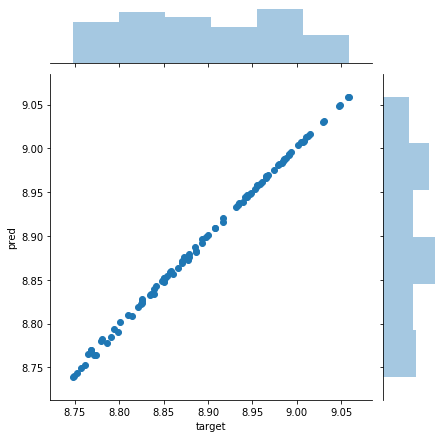

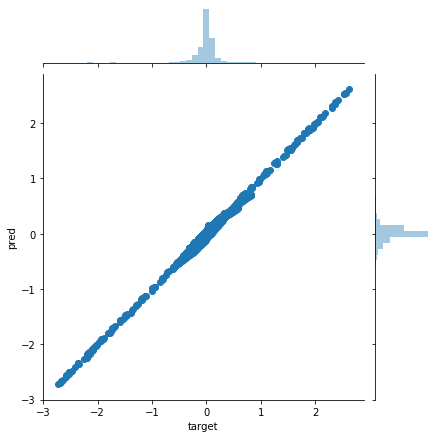

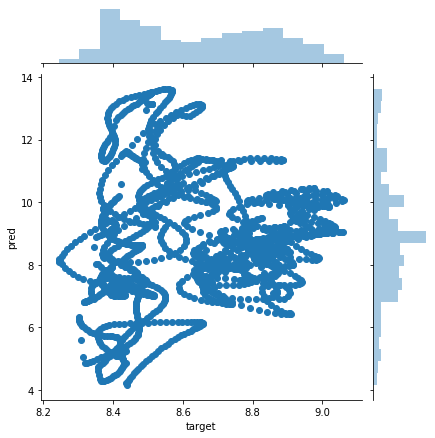

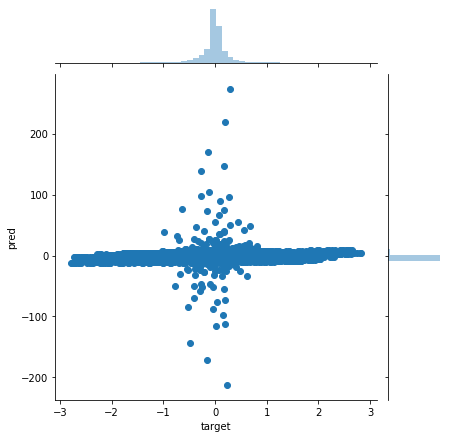

In [6]:
ml_calc = train(training_images)


pred_energies_test = [ml_calc.get_potential_energy(image) for image in test_images]
pred_forces_test = [ml_calc.get_forces(image) for image in test_images]
pred_energies_train = [ml_calc.get_potential_energy(image) for image in training_images]
pred_forces_train = [ml_calc.get_forces(image) for image in training_images]

parity_plots(training_energies, pred_energies_train, 'target', 'pred', 'energy parity', num_atoms=29, dtype="energy")
parity_plots(training_forces, pred_forces_train, 'target', 'pred', 'force parity', num_atoms=29, dtype="force")

parity_plots(target_energies, pred_energies_test, 'target', 'pred', 'energy parity', num_atoms=29, dtype="energy")
parity_plots(target_forces, pred_forces_test, 'target', 'pred', 'force parity', num_atoms=29, dtype="force")

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.2799         17.1348      591.1199  7.3404
      2          0.0908          3.3629       23.0298  8.1505
      3          0.0311          1.4562        4.2894  7.5343
      4          0.0190          1.0660        2.2909  7.9000
      5          0.0229          0.9543        1.8476  7.8999
      6          0.0129          0.8814        1.5620  8.0455
      7          0.0108          0.7409        1.1038  8.6950
      8          0.0096          0.5981        0.7201  8.7616
      9          0.0063          0.5316        0.5671  8.7634
     10          0.0037          0.4511        0.4076  8.3330
     11          0.0027          0.3841        0.2954  6.9696
     12          0.0025          0.3437        0.2365  6.9416
     13          0.0013          0.3245        0.2107  7.6845
     14          

    100          0.0004          0.1115        0.0249  7.7117
RMSE: 0.000202eV/atom
RMSE: 0.111042eV/A
RMSE: 0.247110eV/atom
RMSE: 7.181155eV/A


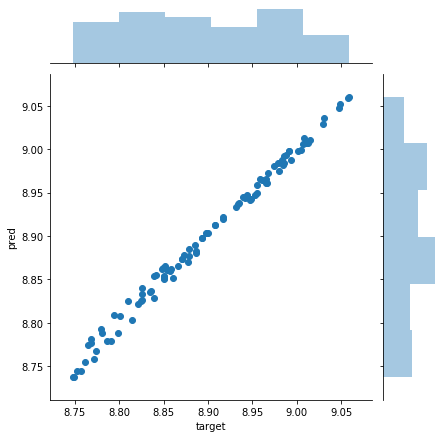

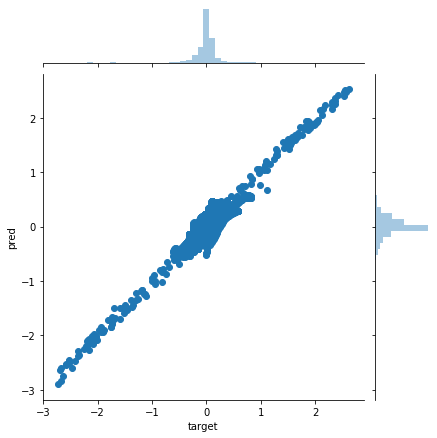

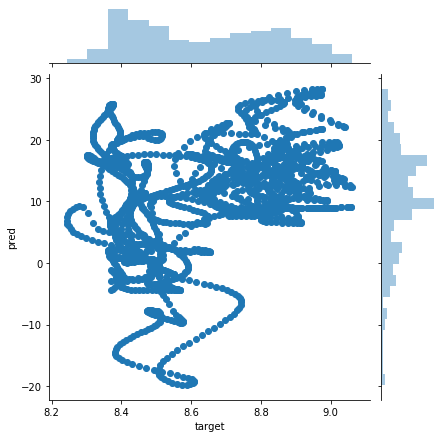

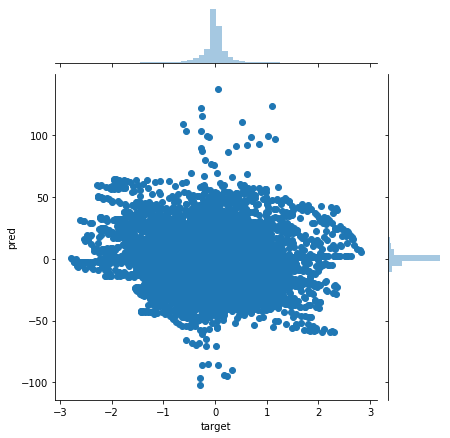

In [7]:
p0 = [  0.972,
        6.379,
        1.09,
        8.575,
        2.168,
        3.8386,
    ]

rep_calc = train(training_images, forcesonly=True, fit=False, p0=p0, lj='rep', method='Nelder-Mead')

pred_energies_test = [rep_calc.get_potential_energy(image) for image in test_images]
pred_forces_test = [rep_calc.get_forces(image) for image in test_images]
pred_energies_train = [rep_calc.get_potential_energy(image) for image in training_images]
pred_forces_train = [rep_calc.get_forces(image) for image in training_images]

parity_plots(training_energies, pred_energies_train, 'target', 'pred', 'energy parity', num_atoms=29, dtype="energy")
parity_plots(training_forces, pred_forces_train, 'target', 'pred', 'force parity', num_atoms=29, dtype="force")

parity_plots(target_energies, pred_energies_test, 'target', 'pred', 'energy parity', num_atoms=29, dtype="energy")
parity_plots(target_forces, pred_forces_test, 'target', 'pred', 'force parity', num_atoms=29, dtype="force")

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.2364         25.8539     1339.6478  8.8589
      2          0.1841          8.3496      141.1270  8.3330
      3          0.0555          2.8465       16.3596  8.2219
      4          0.0268          1.6495        5.4778  8.5750
      5          0.0210          1.4025        3.9560  8.6741
      6          0.0246          1.3013        3.4174  8.8891
      7          0.0187          1.2366        3.0758  8.3294
      8          0.0195          1.1942        2.8715  9.0030
      9          0.0202          1.1524        2.6763  8.3988
     10          0.0186          1.1158        2.5072  8.5430
     11          0.0147          1.0493        2.2129  8.4537
     12          0.0132          0.9613        1.8571  8.5655
     13          0.0156          0.8742        1.5408  8.3261
     14          

     98          0.0011          0.2812        0.1582  7.4555
     99          0.0010          0.2796        0.1564  7.1784
    100          0.0012          0.2783        0.1550  7.1719
RMSE: 0.001045eV/atom
RMSE: 0.276672eV/A
RMSE: 1.145361eV/atom
RMSE: 9.820990eV/A


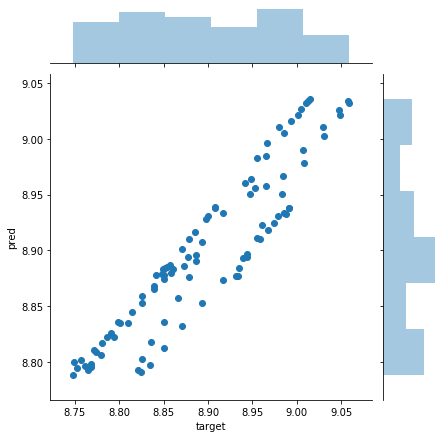

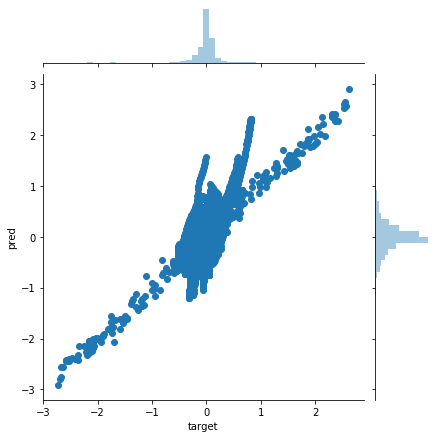

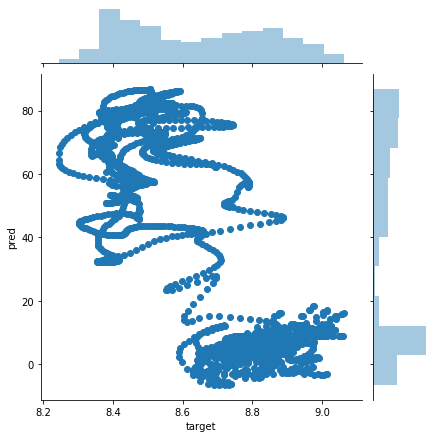

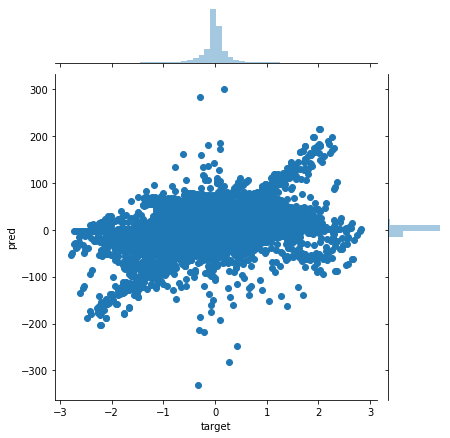

In [8]:
p0 = [  0.972,
        6.379,
        1.09,
        8.575,
        2.168,
        3.8386,
    ]

lj_12_6_calc = train(training_images, forcesonly=False, fit=False, p0=p0, lj='12_6', method='TNC')

pred_energies_test = [lj_12_6_calc.get_potential_energy(image) for image in test_images]
pred_forces_test = [lj_12_6_calc.get_forces(image) for image in test_images]
pred_energies_train = [lj_12_6_calc.get_potential_energy(image) for image in training_images]
pred_forces_train = [lj_12_6_calc.get_forces(image) for image in training_images]

parity_plots(training_energies, pred_energies_train, 'target', 'pred', 'energy parity', num_atoms=29, dtype="energy")
parity_plots(training_forces, pred_forces_train, 'target', 'pred', 'force parity', num_atoms=29, dtype="force")

parity_plots(target_energies, pred_energies_test, 'target', 'pred', 'energy parity', num_atoms=29, dtype="energy")
parity_plots(target_forces, pred_forces_test, 'target', 'pred', 'force parity', num_atoms=29, dtype="force")

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss     dur
-------  --------------  --------------  ------------  ------
      1          0.1140          5.4625       60.3287  8.1770
      2          0.0041          0.4073        0.3326  8.5568
      3          0.0018          0.1635        0.0536  8.7922
      4          0.0022          0.1158        0.0270  9.1512
      5          0.0019          0.0981        0.0194  8.7355
      6          0.0010          0.0730        0.0107  8.8311
      7          0.0009          0.0640        0.0082  8.3024
      8          0.0009          0.0601        0.0073  8.5841
      9          0.0008          0.0589        0.0070  8.4050
     10          0.0008          0.0558        0.0063  8.3945
     11          0.0007          0.0546        0.0060  8.5632
     12          0.0005          0.0531        0.0056  9.0209
     13          0.0006          0.0502        0.0051  8.7185
     14          

     99          0.0003          0.0179        0.0006  8.7450
    100          0.0003          0.0178        0.0006  8.1638
RMSE: 0.000219eV/atom
RMSE: 0.017767eV/A
RMSE: 0.076746eV/atom
RMSE: 1.976392eV/A


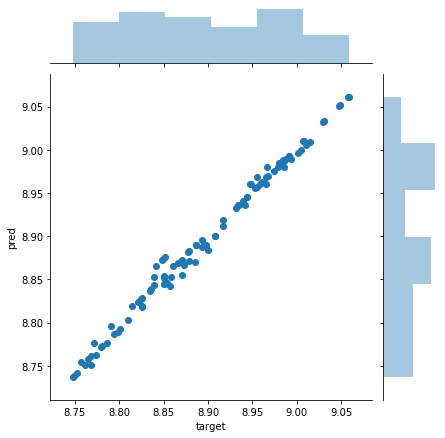

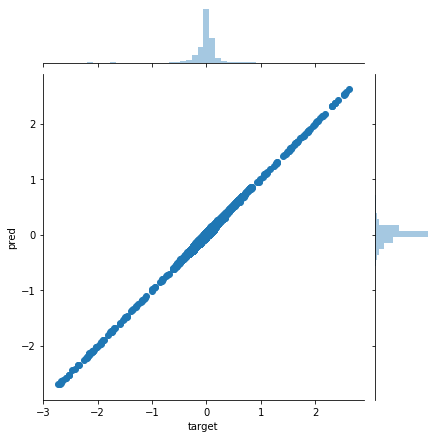

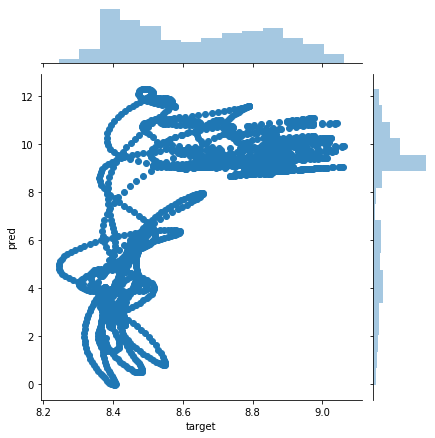

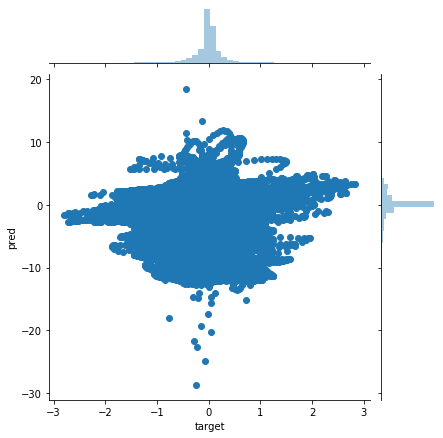

In [9]:
p0 = [  0.972,
        6.379,
        0.477,
        1.09,
        8.575,
        0.603,
        2.168,
        3.8386,
        1.696,
    ]
morse_calc = train(training_images, forcesonly=False, fit=False, p0=p0, lj='morse', method='TNC')

pred_energies_test = [morse_calc.get_potential_energy(image) for image in test_images]
pred_forces_test = [morse_calc.get_forces(image) for image in test_images]
pred_energies_train = [morse_calc.get_potential_energy(image) for image in training_images]
pred_forces_train = [morse_calc.get_forces(image) for image in training_images]

parity_plots(training_energies, pred_energies_train, 'target', 'pred', 'energy parity', num_atoms=29, dtype="energy")
parity_plots(training_forces, pred_forces_train, 'target', 'pred', 'force parity', num_atoms=29, dtype="force")

parity_plots(target_energies, pred_energies_test, 'target', 'pred', 'energy parity', num_atoms=29, dtype="energy")
parity_plots(target_forces, pred_forces_test, 'target', 'pred', 'force parity', num_atoms=29, dtype="force")